# Topic Modeling
### Find Topic Proportion for each review text

In [4]:
import warnings
warnings.filterwarnings('ignore')

import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pattern.en import lemma

import nltk
from nltk.corpus import stopwords

from pprint import pprint

In [5]:
reviews = pd.read_csv('../data/reviews2.csv')
users = pd.read_csv('../data/users2.csv')
restaurants = pd.read_csv("../data/restaurants2.csv")
print("reviews shape:  ", reviews.shape)

reviews shape:   (1707861, 9)


In [6]:
selected_user_id = users['user_id'].sample(n=500, random_state = 48)

category_columns = [c for c in restaurants.columns if 'cat_' in c] 
selected_business_id = set()
for c in category_columns:
    selected_business_id = selected_business_id.union(set(restaurants[restaurants[c]==1].sample(n=80, random_state=48)['business_id']))

In [7]:
print("num of business sampled:  ", len(selected_business_id))
print("num of user sampled:  ", len(selected_user_id))

num of business sampled:   1250
num of user sampled:   500


In [8]:
k=5
np.random.seed(48)
selected_indices = np.array([])
for a in reviews.groupby(['business_id']).indices.values():
    if len(a) <= k:
        selected_indices = np.hstack([selected_indices, a])
    else:
        selected_indices = np.hstack([selected_indices, np.random.choice(a, k)])

In [9]:
selected_reviews = reviews[(reviews['user_id'].isin(selected_user_id)) &\
                           (reviews['business_id'].isin(selected_business_id))]
selected_reviews = reviews.loc[selected_indices]
print("Selected reviews count:  ", selected_reviews.shape)

comment2 = selected_reviews['text'].to_frame().copy().reset_index(drop=True)

Selected reviews count:   (89609, 9)


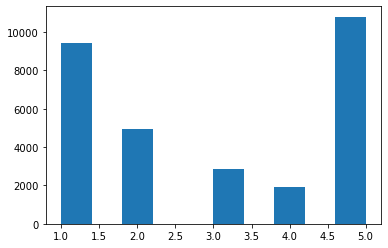

In [10]:
plt.hist(selected_reviews.groupby('business_id')['user_id'].count().values)
plt.show()

### Preliminary Text Pre-processing
- remove special characters
- convert to lower case
- remove stop words

In [11]:
word_count = sorted(Counter(" ".join(comment2['text'].to_list()).lower().split()).items(), key = lambda x: x[1], reverse=True)
oq, lq = np.quantile([i[1] for i in word_count], [0.05, 0.999])
removed_words = [i[0] for i in word_count if i[1] <= 1 or i[1] >= lq]
print("Remove criterion:  {} < wordcount < {}".format(oq, lq))
print("Total words:  {},  Removed words:  {}".format(len(word_count), len(removed_words)))
# plt.plot(np.arange(0, 1, 0.001), np.quantile([i[1] for i in word_count], np.arange(0, 1, 0.001)))

Remove criterion:  1.0 < wordcount < 5790.079999999958
Total words:  279093,  Removed words:  156577


In [12]:
stop_words = stopwords.words("english")
stop_words.extend(['use','food','good','place', 'great', 'like', 'really', 'get', 'eat', 
                   'come', 'also', 'go', 'time', 'order', 'restaurant', 'make', 'one', 'side',
                  'take', 'taste', 'delicious', 'say'])
stop_words.extend(removed_words)
stop_words = set(stop_words)

In [ ]:
## Remove special characters
comment2['text_processed'] = comment2['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# lowercases, tokenizes, de-accents 
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
comment2['text_processed'] = list(sent_to_words(comment2['text_processed']))
print("Gensim Preprocessed Done")

# Remove stopwords
%timeit comment2['text_processed'] = comment2['text_processed'].apply(lambda x: [w for w in x if w not in stop_words])
print("Removed stopwords done")

# Lemmatize
comment2['text_processed'] = comment2['text_processed'].apply(lambda x: [lemma(w) for w in x])
print("Lemmatized Done")

# Remove stopwords
%timeit comment2['text_processed'] = comment2['text_processed'].apply(lambda x: [w for w in x if w not in stop_words])
print("Removed stopwords done")

Gensim Preprocessed Done
378 ms ± 6.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Removed stopwords done


In [ ]:
print('Original: ', comment2.iloc[1]['text'], '\n')
print('Preprocessed:  ', comment2.iloc[1]['text_processed'])

In [54]:
print('Original: ', comment2.iloc[1]['text'], '\n')
print('Preprocessed:  ', comment2.iloc[1]['text_processed'])

Original:  This has been the year of the Banh Mi for my husband and I. It's like I found out about this miraculous sammie and now cannot eat enough! Something about the balance of crisp fresh veggies, smokey pork and spicy sriracha is just heaven.

The folks who run Me So Hungry are fun. I always have some form of a funny conversation with the guys and it helps when I have to sit in the sun and fry while waiting for lunch. 

Their Banh Mi are delicious and huge. However, having frequented a few other places, my big complaint would be too much mayo. Until Banh Mi I hated mayo. Big yuck! However, it provides such an important balance to the sandwich that it's a necessity. I do not like when it oozes out because there is so much and that is what happens to me every time at Me So Hungry. So what do you do? Tell them to go light on the mayo and you are good to go!

Go here. It's delicious and in a trailer! 

Preprocessed:   ['year', 'banh', 'mi', 'husband', 'found', 'miraculous', 'sammie', 

In [55]:
# Create Dictionary
id2word = corpora.Dictionary(comment2['text_processed'])
id2word.filter_extremes(no_above=0.7, no_below=2)

# Term Document Frequency
corpus = comment2['text_processed'].map(id2word.doc2bow)

# View
print("Number of Tokens:  ", len(id2word))

Number of Tokens:   44176


### Train LDA model

In [56]:
for num_topics in range(3, 16):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state = 48)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=comment2['text_processed'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('num_topics:  {}, Coherence Score: {}'.format(num_topics, coherence_lda))

num_topics:  3, Coherence Score: 0.25458159840159156
num_topics:  4, Coherence Score: 0.2708684026005794
num_topics:  5, Coherence Score: 0.27186478218198584
num_topics:  6, Coherence Score: 0.2684895061924789
num_topics:  7, Coherence Score: 0.26820939035004515
num_topics:  8, Coherence Score: 0.27663577487247903
num_topics:  9, Coherence Score: 0.28279975857386425
num_topics:  10, Coherence Score: 0.28158336422226105
num_topics:  11, Coherence Score: 0.27775981427002533
num_topics:  12, Coherence Score: 0.28520270605005144
num_topics:  13, Coherence Score: 0.284752191640273
num_topics:  14, Coherence Score: 0.28461164571788783
num_topics:  15, Coherence Score: 0.28232945473151244


In [69]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state = 48)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"cream" + 0.003*"ice" + 0.003*"free" + 0.002*"chips" + '
  '0.002*"overall" + 0.002*"tacos" + 0.002*"beans" + 0.002*"perfect" + '
  '0.002*"options" + 0.002*"line"'),
 (1,
  '0.004*"taco" + 0.003*"cheap" + 0.002*"items" + 0.002*"friends" + '
  '0.002*"work" + 0.002*"home" + 0.002*"however" + 0.002*"perfect" + '
  '0.002*"old" + 0.002*"special"'),
 (2,
  '0.003*"lobster" + 0.003*"bbq" + 0.003*"atmosphere" + 0.003*"excellent" + '
  '0.003*"however" + 0.002*"roll" + 0.002*"amazing" + 0.002*"looked" + '
  '0.002*"top" + 0.002*"visit"'),
 (3,
  '0.004*"thai" + 0.003*"stars" + 0.003*"top" + 0.003*"hour" + 0.002*"half" + '
  '0.002*"quality" + 0.002*"visit" + 0.002*"price" + 0.002*"three" + '
  '0.002*"friends"'),
 (4,
  '0.003*"ok" + 0.002*"pho" + 0.002*"home" + 0.002*"wine" + 0.002*"shrimp" + '
  '0.002*"tea" + 0.002*"roll" + 0.002*"least" + 0.002*"eating" + '
  '0.002*"anything"'),
 (5,
  '0.003*"home" + 0.002*"chinese" + 0.002*"price" + 0.002*"recommend" + '
  '0.002*"used" 

In [70]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=comment2['text_processed'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.28318668580921746


In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003334 -0.007108       1        1  13.032745
8      0.007804 -0.004995       2        1  12.291142
3     -0.001089  0.002305       3        1  11.366666
9      0.000064 -0.007091       4        1  10.761848
5      0.003875 -0.004304       5        1  10.343140
2      0.021302 -0.005379       6        1  10.205214
6     -0.003324 -0.009364       7        1   9.799952
4     -0.000517 -0.001822       8        1   9.246777
1     -0.030825  0.003006       9        1   6.478824
7      0.006045  0.034752      10        1   6.473692, topic_info=         Term         Freq        Total Category  logprob  loglift
516      taco  5180.000000  5180.000000  Default  30.0000  30.0000
892      fast  6552.000000  6552.000000  Default  29.0000  29.0000
2395  lobster  2865.000000  2865.000000  Default  28.0000  28.0000
146     rolls  5413.000000  5413.000000  Default  27.0000  27.0000
2042     thai  6057.000000  6057.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
519       top   524.680016  7305.015085  Topic10  -6.3481   0.1039
974      size   460.798432  4933.027558  Topic10  -6.4780   0.3667
379   usually   476.603027  5692.805536  Topic10  -6.4443   0.2571
557   perfect   495.129684  7469.961478  Topic10  -6.4061   0.0236
195      free   478.510439  7641.177880  Topic10  -6.4403  -0.0332

[957 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
16976      1  0.029670  absinthe
16976      3  0.029670  absinthe
16976      5  0.652748  absinthe
16976      6  0.029670  absinthe
16976      7  0.059341  absinthe
...      ...       ...       ...
25747      6  0.053952        zi
25747      7  0.053952        zi
25747      8  0.053952        zi
31662      7  0.830601      zoey
32250      8  0.869878       zuk

[3984 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 4, 10, 6, 3, 7, 5, 2, 8])

In [72]:
topics = pd.DataFrame([[k[1] for k in lda_model.get_document_topics(corpus.iloc[i], minimum_probability=0)] for i in range(comment2.shape[0])])
text_with_topic_proportion = pd.concat([comment2.reset_index(drop=True), topics], axis=1)
text_with_topic_proportion['majorTopic'] = topics.idxmax(1)
text_with_topic_proportion.head()

,text,text_processed,0,1,2,3,4,5,6,7,8,9,majorTopic
0,I just had what may have been the best salad o...,"[may, life, kidding, life, changing, trailer, ...",0.001856,0.001856,0.001856,0.001856,0.001856,0.983295,0.001856,0.001856,0.001856,0.001856,5
1,This has been the year of the Banh Mi for my h...,"[year, banh, mi, husband, found, miraculous, s...",0.001965,0.413888,0.001965,0.001965,0.570396,0.001965,0.001965,0.001965,0.001965,0.001965,4
2,Me So Hungry left Me So Sort Of Satisfied. I h...,"[hungry, left, sort, satisfied, headed, ready,...",0.000783,0.000783,0.000783,0.000783,0.376957,0.000783,0.000783,0.000783,0.000783,0.616776,9
3,Me so bummed. Me left so hungry.\n\nI used to ...,"[bummed, left, hungry, used, opened, years, dr...",0.001257,0.001257,0.001257,0.001257,0.988690,0.001257,0.001257,0.001257,0.001257,0.001257,4
4,I am just going to say it cause I already told...,"[cause, already, told, companions, marry, cute...",0.001433,0.001433,0.001433,0.001433,0.500279,0.001433,0.488259,0.001433,0.001433,0.001433,4


### Plot word cloud for each topic

In [62]:
from wordcloud import WordCloud

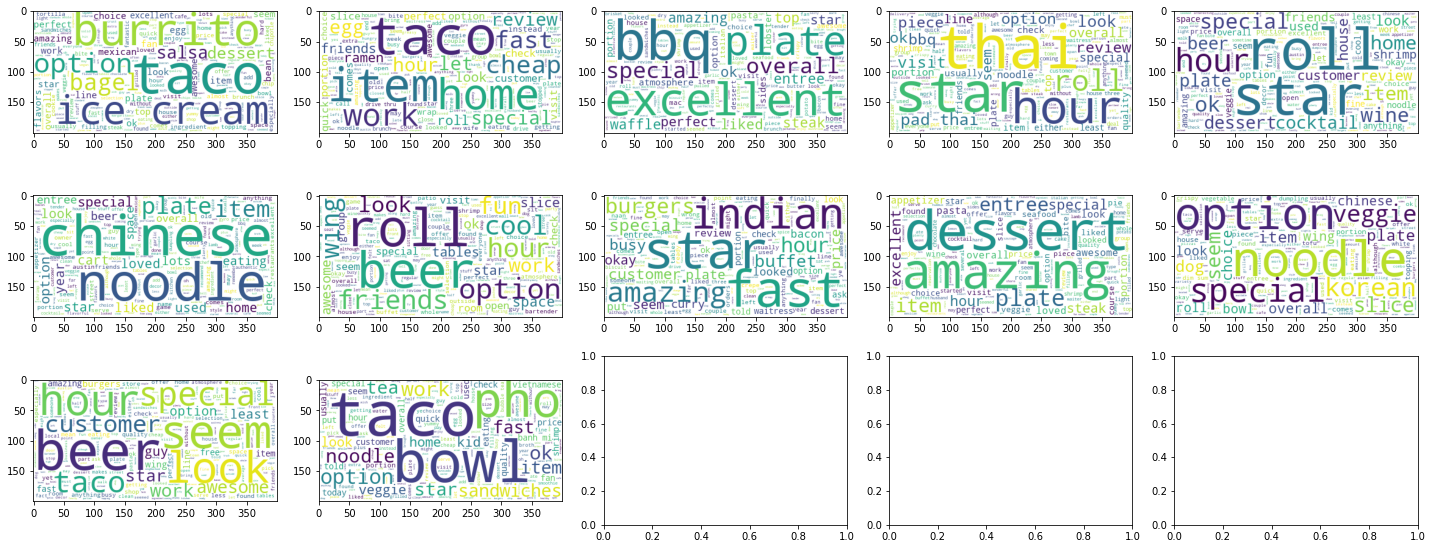

In [63]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
fig, axes = plt.subplots(3, 5, figsize = (20, 8))
for i in range(num_topics):
    ax = axes[i//5, i%5]
    text_to_plot = text_with_topic_proportion[text_with_topic_proportion['majorTopic'] == i]['text_processed'].to_list()
    text_to_plot = [i for l in text_to_plot for i in l]
    wordcloud.generate(" ".join(text_to_plot))
    ax.imshow(wordcloud)
plt.tight_layout()
plt.show()

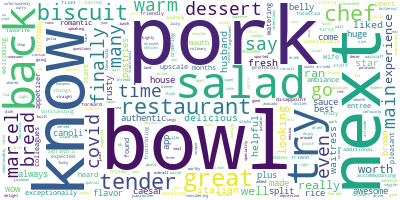

In [73]:
comment_3 = comment2[maxValueIndexObj==3]
data3 = comment_3.text_processed.values.tolist()

import numpy as np
a = list(np.concatenate(data_words3).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

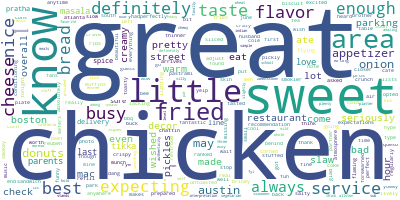

In [74]:
comment_4 = comment2[maxValueIndexObj==4]
data4 = comment_4.text_processed.values.tolist()
data_words4 = list(sent_to_words(data4))
# remove stop words
data_words4 = remove_stopwords(data_words4)
import numpy as np
a = list(np.concatenate(data_words4).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

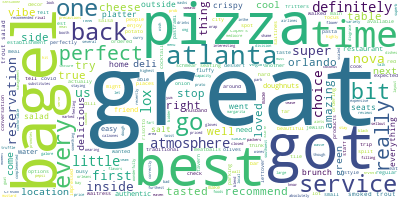

In [75]:
comment_5 = comment2[maxValueIndexObj==5]
data5 = comment_5.text_processed.values.tolist()
data_words5 = list(sent_to_words(data5))
# remove stop words
data_words5 = remove_stopwords(data_words5)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

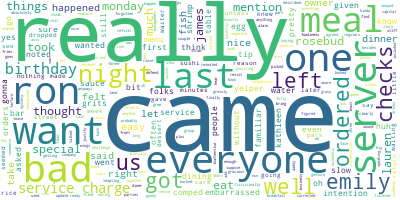

In [76]:
comment_6 = comment2[maxValueIndexObj==6]
data6 = comment_6.text_processed.values.tolist()
data_words6 = list(sent_to_words(data6))
# remove stop words
data_words6 = remove_stopwords(data_words6)
import numpy as np
a = list(np.concatenate(data_words6).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

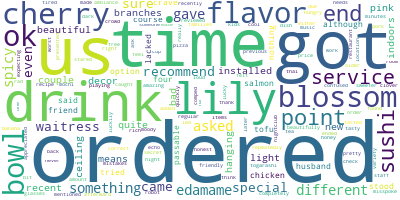

In [78]:
comment_7 = comment2[maxValueIndexObj==7]
data7 = comment_7.text_processed.values.tolist()
data_words7 = list(sent_to_words(data7))
# remove stop words
data_words7 = remove_stopwords(data_words7)
import numpy as np
a = list(np.concatenate(data_words7).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

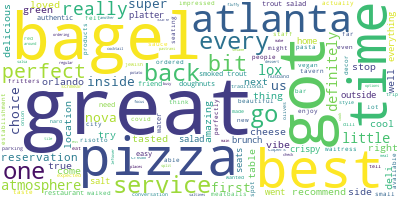

In [79]:
comment_8 = comment2[maxValueIndexObj==8]
data8 = comment_8.text_processed.values.tolist()
data_words8 = list(sent_to_words(data8))
# remove stop words
data_words8 = remove_stopwords(data_words8)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

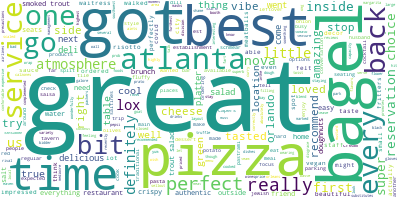

In [80]:
comment_9 = comment2[maxValueIndexObj==9]
data9 = comment_9.text_processed.values.tolist()
data_words9 = list(sent_to_words(data9))
# remove stop words
data_words9 = remove_stopwords(data_words9)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()